In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp

from PIL import Image
import os

In [2]:
#import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

Instructions for updating:
non-resource variables are not supported in the long term


In [26]:
# For moving all img files from one root dir to another
# source = "Train"
# dest = "Train1"

# label_flood_dir = os.path.join('Labeled','Flooded','image')
# label_nonflood_dir = os.path.join('Labeled','Non-Flooded','image')

# for dire in label_flood_dir,label_nonflood_dir:
#     source_dir = os.path.join(source,dire)
#     dest_dir = os.path.join(dest,dire)
#     for file in os.listdir(source_dir):
#         source_file = os.path.join(source_dir,file)
#         dest_file = os.path.join(dest_dir,file)
#         os.rename(source_file,dest_file)

Should take around 3 minutes to load

In [9]:
h_dim = 1000
v_dim = 750
print("Loading Data from Memory")

root = "Train"
label_flood_dir = os.path.join(root,'Labeled','Flooded','image')
label_nonflood_dir = os.path.join(root,'Labeled','Non-Flooded','image')
flooded_img = []
nonflooded_img = []

for file in os.listdir(label_flood_dir):
    image = Image.open(os.path.join(label_flood_dir, file))
    flooded_img.append(np.array(image.resize((h_dim,v_dim))))
    
for file in os.listdir(label_nonflood_dir):
    image = Image.open(os.path.join(label_nonflood_dir, file))
    nonflooded_img.append(np.array(image.resize((h_dim,v_dim))))
print("Loaded!")

Loading Data from Memory
Loaded!


In [10]:
print("Flooded Image Shape: {}".format(flooded_img[0].shape))
print("Non_Flooded Image Shape: {}".format(nonflooded_img[0].shape))

data_img = np.vstack((np.array(flooded_img), np.array(nonflooded_img))) / 255.
data_img.shape

Flooded Image Shape: (750, 1000, 3)
Non_Flooded Image Shape: (750, 1000, 3)


(397, 750, 1000, 3)

In [38]:
import random
test = False

#n is number images from each class (flooded or non flooded)
if test == True:
    n = 20
    #train_idx = np.array([np.arange(7),np.arange(10,17)]).flatten()
    #test_idx = np.array([np.arange(7,10),np.arange(17,20)]).flatten()
else:
    n = min(len(flooded_img),len(nonflooded_img))

'''split data 50 50'''
def train_test_split(n):
    idxs = list(range(n))
    s = int(np.floor(0.8*n)) # number of images for training
    
    train_idx = []
    test_idx = []
    
    #index range to select from (flooded img range, non flooded image range)
    for s_i,e_i in [(0,len(flooded_img)),(len(flooded_img),len(data_img))]:
        
        #print(s_i,e_i,n,s)
        #get all poss indexes for set
        s_idx = list(range(s_i,e_i))
        random.shuffle(s_idx)
        
        train_idx.extend(s_idx[:s])      #first s images are for training
        test_idx.extend(s_idx[s:n])      # next n-s images are for testing. 
        #print(len(train_idx))
    
    train_idx = np.array(train_idx)
    test_idx = np.array(test_idx)
    train_idx.sort()
    test_idx.sort()
    
    train_labels = [1 if x<len(flooded_img) else 0 for x in train_idx]
    test_labels = [1 if x<len(flooded_img) else 0 for x in test_idx]

    print("Training Index: {}".format(train_idx))
    print("Testing Index: {}".format(test_idx))
    return train_idx, test_idx, train_labels, test_labels

train_idx, test_idx, train_labels, test_labels = train_test_split(n)


Training Index: [  0   1   2   3   4   5   6   7   9  10  11  13  14  15  16  18  20  22
  23  25  26  27  28  29  30  32  35  36  37  38  39  40  42  43  44  45
  46  47  49  50  53  75 111 124 130 148 163 165 166 172 176 184 190 212
 218 225 242 251 257 280 283 286 289 294 300 309 310 313 316 317 334 350
 355 358 361 372 383 386 387 393]
Testing Index: [  8  12  17  19  21  24  31  33  34  41  48  69  81 134 141 188 233 275
 285 306 348 389]


In [39]:
# convolutional layer
# x the input 
# shape is dimension of input
def conv_layer(x, shape):

    weights = tf.Variable(tf.truncated_normal(shape, stddev=0.05))
    bias = tf.Variable(tf.constant(0.05, shape=[shape[-1]]))

    out = tf.nn.conv2d(input=x, filters=weights, strides=[1,1,1,1], padding='SAME')
    out += bias
    return out

# pooling layer
def max_pool(x, k=2):

    out = tf.nn.max_pool(value=x, ksize=[1, k, k, 1], strides=[1, k, k, 1], padding='SAME')
    return out

# fully connected layer
def fully_connected_layer(x, shape):

    weights = tf.Variable(tf.truncated_normal(shape, stddev=0.05))
    bias = tf.Variable(tf.constant(0.05, shape=[shape[1]]))

    out = tf.matmul(a=x, b=weights)
    out += bias
    return out

# flatten layer
def flatten_layer(x):
    
    size = x.get_shape()[1:4].num_elements()
    out = tf.reshape(x, [-1,size])
    return out, size

# relu
relu = lambda x: tf.nn.relu(features=x)

# softmax
softmax = lambda x: tf.nn.softmax(logits=x)

# sigmoid
sigmoid = lambda x: tf.nn.sigmoid(x)

# batch norm
batch_norm = lambda x: tf.layers.batch_normalization(x)

In [40]:
# define CNN
def toy_model(x):

    # Six convolutional layers with max pool and ReLU
    shape0 = [5, 5, 3, 3]
    conv0 = conv_layer(x, shape0)
    conv0 = relu(conv0)
    conv0 = batch_norm(conv0)
    conv0 = max_pool(conv0, k=2)

    shape1 = [5, 5, 3, 3]
    conv1 = conv_layer(conv0, shape1)
    conv1 = relu(conv1)
    conv1 = batch_norm(conv1)
    conv1 = max_pool(conv1, k=2)

    shape2 = [5, 5, 3, 3]
    conv2 = conv_layer(conv1, shape2)
    conv2 = relu(conv2)
    conv2 = batch_norm(conv2)
    conv2 = max_pool(conv2, k=2)

    shape3 = [5, 5, 3, 1]
    conv3 = conv_layer(conv2, shape3)
    conv3 = relu(conv3)
    conv3 = batch_norm(conv3)
    conv3 = max_pool(conv3, k=2)

    shape4 = [5, 5, 1, 1]
    conv4 = conv_layer(conv3, shape4)
    conv4 = relu(conv4)
    conv4 = batch_norm(conv4)
    conv4 = max_pool(conv4, k=2)

    shape5 = [5, 5, 1, 1]
    conv5 = conv_layer(conv4, shape5)
    conv5 = relu(conv5)
    conv5 = batch_norm(conv5)
    conv5 = max_pool(conv5, k=2)

    # flatten output and put through a fully connected layer
    flat1, size1 = flatten_layer(conv5)
    fc1 = fully_connected_layer(flat1, [size1, 64])
    fc1 = relu(fc1)

    fc2 = fully_connected_layer(fc1, [64, 1])

    return fc2

In [41]:
def sharpen(p):
    T = 0.5
    pred = p**(1./T)/(p**(1./T) + (1.-p)**(1./T))
    return pred

In [42]:
# define inputs
x = tf.placeholder(tf.float32, [None, v_dim, h_dim, 3])
y = tf.placeholder(tf.float32, [None, 1])
y_train_true = np.array(train_labels).reshape(-1,1)
y_test_true = np.array(test_labels).reshape(-1,1)

# run model with placeholder tensors
pred = toy_model(x)

# sharpen
# pred = sharpen(pred)

# define loss
cross_entropy = tf.losses.sigmoid_cross_entropy(logits=pred, multi_class_labels=y)
cost = tf.reduce_mean(cross_entropy)

# define accuracy
pred_class = tf.round(sigmoid(pred))
pred_correct = tf.equal(pred_class, tf.cast(y, tf.float32))
accuracy = tf.reduce_mean(tf.cast(pred_correct, tf.float32))

# define optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=1e-3).minimize(cost)

# initialize variables
init = tf.global_variables_initializer()
training_iters = 1000
batch_size = 20 #len(train_idx)

In [43]:
# train model
with tf.Session(config=config) as sess:
    sess.run(init)
    train_loss = []
    test_loss = []
    train_accuracy = []
    test_accuracy = []
    summary_writer = tf.summary.FileWriter('./Output', sess.graph)
    num_batches = len(train_idx)//batch_size
    
    for i in range(training_iters):
        
        # Reset metrics
        loss_total = 0
        acc_total = 0
   
        # Run optimization 
        # Calculate batch loss and accuracy
        for batch in range(num_batches):
            batch_x = data_img[train_idx,:,:,:][batch*batch_size:min((batch+1)*batch_size,len(train_idx))]
            batch_y = y_train_true[batch*batch_size:min((batch+1)*batch_size,len(y_train_true))]    

            feed_dict={x: batch_x, y: batch_y}
            opt = sess.run(optimizer, feed_dict=feed_dict)
            loss, acc = sess.run([cost, accuracy], feed_dict=feed_dict)
            loss_total += loss
            acc_total += acc

        # Average metrics
        ave_loss = loss_total/num_batches
        ave_acc = acc_total/num_batches

        # Calculate accuracy for all test images
        valid_loss,test_acc = sess.run([cost,accuracy],
                                feed_dict={x: data_img[test_idx,:,:,:], y : y_test_true})
        train_loss.append(ave_loss)
        test_loss.append(valid_loss)
        train_accuracy.append(ave_acc)
        test_accuracy.append(test_acc)
        print("Iter " + str(i) + ", Loss= " + \
                      "{:.6f}".format(ave_loss) + ", Training Accuracy= " + \
                      "{:.5f}".format(ave_acc)+ \
                      " ,Testing Accuracy:","{:.5f}".format(test_acc))
    summary_writer.close()

Iter 0, Loss= 0.698491, Training Accuracy= 0.50000 ,Testing Accuracy: 0.50000
Iter 1, Loss= 0.694688, Training Accuracy= 0.50000 ,Testing Accuracy: 0.50000
Iter 2, Loss= 0.694031, Training Accuracy= 0.50000 ,Testing Accuracy: 0.50000
Iter 3, Loss= 0.693732, Training Accuracy= 0.50000 ,Testing Accuracy: 0.50000
Iter 4, Loss= 0.693574, Training Accuracy= 0.50000 ,Testing Accuracy: 0.50000
Iter 5, Loss= 0.693462, Training Accuracy= 0.50000 ,Testing Accuracy: 0.50000
Iter 6, Loss= 0.693397, Training Accuracy= 0.50000 ,Testing Accuracy: 0.50000
Iter 7, Loss= 0.693353, Training Accuracy= 0.50000 ,Testing Accuracy: 0.50000
Iter 8, Loss= 0.693316, Training Accuracy= 0.50000 ,Testing Accuracy: 0.50000
Iter 9, Loss= 0.693282, Training Accuracy= 0.50000 ,Testing Accuracy: 0.50000
Iter 10, Loss= 0.693255, Training Accuracy= 0.50000 ,Testing Accuracy: 0.50000
Iter 11, Loss= 0.693233, Training Accuracy= 0.50000 ,Testing Accuracy: 0.50000
Iter 12, Loss= 0.693215, Training Accuracy= 0.50000 ,Testing A

Iter 104, Loss= 0.693133, Training Accuracy= 0.50000 ,Testing Accuracy: 0.50000
Iter 105, Loss= 0.693133, Training Accuracy= 0.50000 ,Testing Accuracy: 0.50000
Iter 106, Loss= 0.693132, Training Accuracy= 0.50000 ,Testing Accuracy: 0.50000
Iter 107, Loss= 0.693131, Training Accuracy= 0.50000 ,Testing Accuracy: 0.50000
Iter 108, Loss= 0.693130, Training Accuracy= 0.50000 ,Testing Accuracy: 0.50000
Iter 109, Loss= 0.693129, Training Accuracy= 0.50000 ,Testing Accuracy: 0.50000
Iter 110, Loss= 0.693128, Training Accuracy= 0.50000 ,Testing Accuracy: 0.50000
Iter 111, Loss= 0.693127, Training Accuracy= 0.50000 ,Testing Accuracy: 0.50000
Iter 112, Loss= 0.693126, Training Accuracy= 0.50000 ,Testing Accuracy: 0.50000
Iter 113, Loss= 0.693125, Training Accuracy= 0.50000 ,Testing Accuracy: 0.50000
Iter 114, Loss= 0.693124, Training Accuracy= 0.50000 ,Testing Accuracy: 0.50000
Iter 115, Loss= 0.693122, Training Accuracy= 0.50000 ,Testing Accuracy: 0.50000
Iter 116, Loss= 0.693117, Training Accur

Iter 207, Loss= 0.338600, Training Accuracy= 0.83750 ,Testing Accuracy: 0.81818
Iter 208, Loss= 0.323146, Training Accuracy= 0.83750 ,Testing Accuracy: 0.81818
Iter 209, Loss= 0.324159, Training Accuracy= 0.85000 ,Testing Accuracy: 0.81818
Iter 210, Loss= 0.319904, Training Accuracy= 0.86250 ,Testing Accuracy: 0.81818
Iter 211, Loss= 0.312853, Training Accuracy= 0.86250 ,Testing Accuracy: 0.81818
Iter 212, Loss= 0.312004, Training Accuracy= 0.86250 ,Testing Accuracy: 0.81818
Iter 213, Loss= 0.304689, Training Accuracy= 0.86250 ,Testing Accuracy: 0.81818
Iter 214, Loss= 0.302856, Training Accuracy= 0.87500 ,Testing Accuracy: 0.81818
Iter 215, Loss= 0.297096, Training Accuracy= 0.90000 ,Testing Accuracy: 0.81818
Iter 216, Loss= 0.292884, Training Accuracy= 0.91250 ,Testing Accuracy: 0.81818
Iter 217, Loss= 0.289083, Training Accuracy= 0.91250 ,Testing Accuracy: 0.81818
Iter 218, Loss= 0.283332, Training Accuracy= 0.91250 ,Testing Accuracy: 0.81818
Iter 219, Loss= 0.279715, Training Accur

Iter 310, Loss= 0.014746, Training Accuracy= 1.00000 ,Testing Accuracy: 0.81818
Iter 311, Loss= 0.012715, Training Accuracy= 1.00000 ,Testing Accuracy: 0.77273
Iter 312, Loss= 0.011540, Training Accuracy= 1.00000 ,Testing Accuracy: 0.77273
Iter 313, Loss= 0.009955, Training Accuracy= 1.00000 ,Testing Accuracy: 0.77273
Iter 314, Loss= 0.009786, Training Accuracy= 1.00000 ,Testing Accuracy: 0.81818
Iter 315, Loss= 0.009736, Training Accuracy= 1.00000 ,Testing Accuracy: 0.77273
Iter 316, Loss= 0.009260, Training Accuracy= 1.00000 ,Testing Accuracy: 0.77273
Iter 317, Loss= 0.008713, Training Accuracy= 1.00000 ,Testing Accuracy: 0.77273
Iter 318, Loss= 0.008296, Training Accuracy= 1.00000 ,Testing Accuracy: 0.77273
Iter 319, Loss= 0.008037, Training Accuracy= 1.00000 ,Testing Accuracy: 0.77273
Iter 320, Loss= 0.007795, Training Accuracy= 1.00000 ,Testing Accuracy: 0.77273
Iter 321, Loss= 0.007496, Training Accuracy= 1.00000 ,Testing Accuracy: 0.77273
Iter 322, Loss= 0.007179, Training Accur

Iter 413, Loss= 0.001133, Training Accuracy= 1.00000 ,Testing Accuracy: 0.77273
Iter 414, Loss= 0.001120, Training Accuracy= 1.00000 ,Testing Accuracy: 0.77273
Iter 415, Loss= 0.001107, Training Accuracy= 1.00000 ,Testing Accuracy: 0.77273
Iter 416, Loss= 0.001094, Training Accuracy= 1.00000 ,Testing Accuracy: 0.77273
Iter 417, Loss= 0.001079, Training Accuracy= 1.00000 ,Testing Accuracy: 0.77273
Iter 418, Loss= 0.001060, Training Accuracy= 1.00000 ,Testing Accuracy: 0.77273
Iter 419, Loss= 0.001051, Training Accuracy= 1.00000 ,Testing Accuracy: 0.77273
Iter 420, Loss= 0.001040, Training Accuracy= 1.00000 ,Testing Accuracy: 0.77273
Iter 421, Loss= 0.001025, Training Accuracy= 1.00000 ,Testing Accuracy: 0.77273
Iter 422, Loss= 0.001013, Training Accuracy= 1.00000 ,Testing Accuracy: 0.77273
Iter 423, Loss= 0.000998, Training Accuracy= 1.00000 ,Testing Accuracy: 0.77273
Iter 424, Loss= 0.000987, Training Accuracy= 1.00000 ,Testing Accuracy: 0.77273
Iter 425, Loss= 0.000976, Training Accur

Iter 516, Loss= 0.000404, Training Accuracy= 1.00000 ,Testing Accuracy: 0.77273
Iter 517, Loss= 0.000402, Training Accuracy= 1.00000 ,Testing Accuracy: 0.77273
Iter 518, Loss= 0.000399, Training Accuracy= 1.00000 ,Testing Accuracy: 0.77273
Iter 519, Loss= 0.000394, Training Accuracy= 1.00000 ,Testing Accuracy: 0.77273
Iter 520, Loss= 0.000392, Training Accuracy= 1.00000 ,Testing Accuracy: 0.77273
Iter 521, Loss= 0.000389, Training Accuracy= 1.00000 ,Testing Accuracy: 0.77273
Iter 522, Loss= 0.000386, Training Accuracy= 1.00000 ,Testing Accuracy: 0.77273
Iter 523, Loss= 0.000382, Training Accuracy= 1.00000 ,Testing Accuracy: 0.77273
Iter 524, Loss= 0.000380, Training Accuracy= 1.00000 ,Testing Accuracy: 0.77273
Iter 525, Loss= 0.000377, Training Accuracy= 1.00000 ,Testing Accuracy: 0.77273
Iter 526, Loss= 0.000374, Training Accuracy= 1.00000 ,Testing Accuracy: 0.77273
Iter 527, Loss= 0.000371, Training Accuracy= 1.00000 ,Testing Accuracy: 0.77273
Iter 528, Loss= 0.000368, Training Accur

Iter 619, Loss= 0.000204, Training Accuracy= 1.00000 ,Testing Accuracy: 0.77273
Iter 620, Loss= 0.000202, Training Accuracy= 1.00000 ,Testing Accuracy: 0.77273
Iter 621, Loss= 0.000201, Training Accuracy= 1.00000 ,Testing Accuracy: 0.77273
Iter 622, Loss= 0.000200, Training Accuracy= 1.00000 ,Testing Accuracy: 0.77273
Iter 623, Loss= 0.000199, Training Accuracy= 1.00000 ,Testing Accuracy: 0.77273
Iter 624, Loss= 0.000198, Training Accuracy= 1.00000 ,Testing Accuracy: 0.77273
Iter 625, Loss= 0.000197, Training Accuracy= 1.00000 ,Testing Accuracy: 0.77273
Iter 626, Loss= 0.000195, Training Accuracy= 1.00000 ,Testing Accuracy: 0.77273
Iter 627, Loss= 0.000195, Training Accuracy= 1.00000 ,Testing Accuracy: 0.77273
Iter 628, Loss= 0.000194, Training Accuracy= 1.00000 ,Testing Accuracy: 0.77273
Iter 629, Loss= 0.000192, Training Accuracy= 1.00000 ,Testing Accuracy: 0.77273
Iter 630, Loss= 0.000191, Training Accuracy= 1.00000 ,Testing Accuracy: 0.77273
Iter 631, Loss= 0.000190, Training Accur

Iter 722, Loss= 0.000120, Training Accuracy= 1.00000 ,Testing Accuracy: 0.77273
Iter 723, Loss= 0.000120, Training Accuracy= 1.00000 ,Testing Accuracy: 0.77273
Iter 724, Loss= 0.000119, Training Accuracy= 1.00000 ,Testing Accuracy: 0.77273
Iter 725, Loss= 0.000118, Training Accuracy= 1.00000 ,Testing Accuracy: 0.77273
Iter 726, Loss= 0.000118, Training Accuracy= 1.00000 ,Testing Accuracy: 0.77273
Iter 727, Loss= 0.000117, Training Accuracy= 1.00000 ,Testing Accuracy: 0.77273
Iter 728, Loss= 0.000117, Training Accuracy= 1.00000 ,Testing Accuracy: 0.77273
Iter 729, Loss= 0.000116, Training Accuracy= 1.00000 ,Testing Accuracy: 0.77273
Iter 730, Loss= 0.000116, Training Accuracy= 1.00000 ,Testing Accuracy: 0.77273
Iter 731, Loss= 0.000115, Training Accuracy= 1.00000 ,Testing Accuracy: 0.77273
Iter 732, Loss= 0.000115, Training Accuracy= 1.00000 ,Testing Accuracy: 0.77273
Iter 733, Loss= 0.000114, Training Accuracy= 1.00000 ,Testing Accuracy: 0.77273
Iter 734, Loss= 0.000114, Training Accur

Iter 825, Loss= 0.000077, Training Accuracy= 1.00000 ,Testing Accuracy: 0.77273
Iter 826, Loss= 0.000077, Training Accuracy= 1.00000 ,Testing Accuracy: 0.77273
Iter 827, Loss= 0.000077, Training Accuracy= 1.00000 ,Testing Accuracy: 0.77273
Iter 828, Loss= 0.000076, Training Accuracy= 1.00000 ,Testing Accuracy: 0.77273
Iter 829, Loss= 0.000076, Training Accuracy= 1.00000 ,Testing Accuracy: 0.77273
Iter 830, Loss= 0.000076, Training Accuracy= 1.00000 ,Testing Accuracy: 0.77273
Iter 831, Loss= 0.000075, Training Accuracy= 1.00000 ,Testing Accuracy: 0.77273
Iter 832, Loss= 0.000075, Training Accuracy= 1.00000 ,Testing Accuracy: 0.77273
Iter 833, Loss= 0.000075, Training Accuracy= 1.00000 ,Testing Accuracy: 0.77273
Iter 834, Loss= 0.000074, Training Accuracy= 1.00000 ,Testing Accuracy: 0.77273
Iter 835, Loss= 0.000074, Training Accuracy= 1.00000 ,Testing Accuracy: 0.77273
Iter 836, Loss= 0.000074, Training Accuracy= 1.00000 ,Testing Accuracy: 0.77273
Iter 837, Loss= 0.000074, Training Accur

Iter 928, Loss= 0.000052, Training Accuracy= 1.00000 ,Testing Accuracy: 0.77273
Iter 929, Loss= 0.000052, Training Accuracy= 1.00000 ,Testing Accuracy: 0.77273
Iter 930, Loss= 0.000052, Training Accuracy= 1.00000 ,Testing Accuracy: 0.77273
Iter 931, Loss= 0.000052, Training Accuracy= 1.00000 ,Testing Accuracy: 0.77273
Iter 932, Loss= 0.000051, Training Accuracy= 1.00000 ,Testing Accuracy: 0.77273
Iter 933, Loss= 0.000051, Training Accuracy= 1.00000 ,Testing Accuracy: 0.77273
Iter 934, Loss= 0.000051, Training Accuracy= 1.00000 ,Testing Accuracy: 0.77273
Iter 935, Loss= 0.000051, Training Accuracy= 1.00000 ,Testing Accuracy: 0.77273
Iter 936, Loss= 0.000051, Training Accuracy= 1.00000 ,Testing Accuracy: 0.77273
Iter 937, Loss= 0.000051, Training Accuracy= 1.00000 ,Testing Accuracy: 0.77273
Iter 938, Loss= 0.000050, Training Accuracy= 1.00000 ,Testing Accuracy: 0.77273
Iter 939, Loss= 0.000050, Training Accuracy= 1.00000 ,Testing Accuracy: 0.77273
Iter 940, Loss= 0.000050, Training Accur

In [27]:
feed_dict = {x: data_img[train_idx,:,:,:], y : y_test_true}
sess.run([pred], feed_dict=feed_dict)

ValueError: Tried to convert 'input' to a tensor and failed. Error: Cannot create a tensor proto whose content is larger than 2GB.

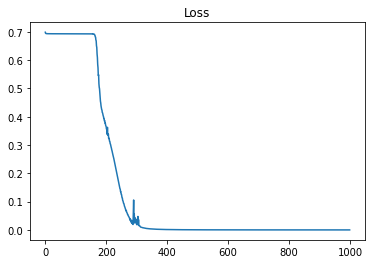

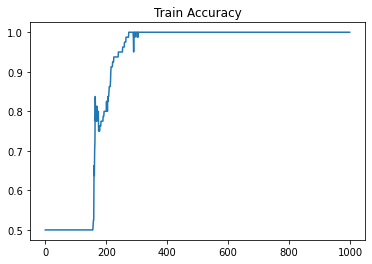

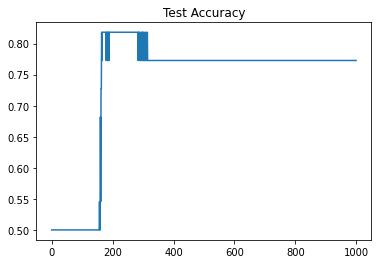

In [44]:
for title, data in {"Loss":train_loss,"Train Accuracy": train_accuracy, "Test Accuracy": test_accuracy}.items():
    plt.plot(data)
    plt.title(title)
    plt.show()